In [30]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import survivors.datasets as ds

import warnings
warnings.filterwarnings("ignore")

In [2]:
# axis_font = {'fontname':'Arial', 'size':'14'}
axis_font = {'fontname':'Times New Roman', 'size':'16'}
sns.set_context(rc={'lines.linewidth':2})

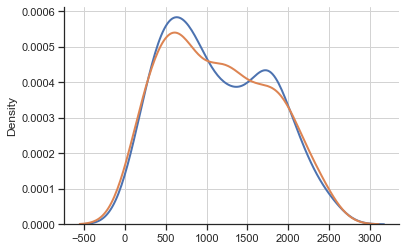

In [3]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from survivors.experiments.grid import generate_sample, prepare_sample, count_metric

# X, y, features, categ, sch_nan = ds.load_actg_dataset()
X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
# X, y, features, categ, sch_nan = ds.load_wuhan_dataset()

qs = np.quantile(y["time"], np.linspace(0.2, 0.8, 4))
time_discr = np.searchsorted(qs, y["time"])

discr = np.char.add(time_discr.astype(str), y["cens"].astype(str))
X_TR, X_HO = train_test_split(X, stratify=discr, test_size=0.33, random_state=42)
X_tr, y_tr, X_HO, y_HO, bins_HO = prepare_sample(X, y, X_TR.index, X_HO.index)

df = X_HO.copy()
df["time"] = y_HO["time"]
df["cens"] = y_HO["cens"]

df_tr = X_tr.copy()
df_tr["time"] = y_tr["time"]
df_tr["cens"] = y_tr["cens"]

sns.kdeplot(y_tr["time"], label="train")
sns.kdeplot(y_HO["time"], label="HO")
plt.show()

<Axes: ylabel='Density'>

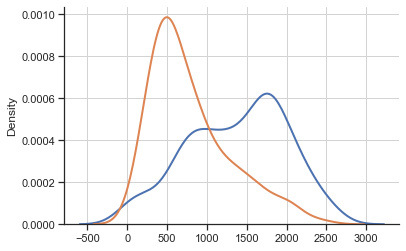

In [4]:
sns.kdeplot(y_tr[np.where(y_tr["cens"] == 0)[0]]["time"], label="train")
sns.kdeplot(y_tr[np.where(y_tr["cens"] == 1)[0]]["time"], label="train")

(0.0, 4000.0)

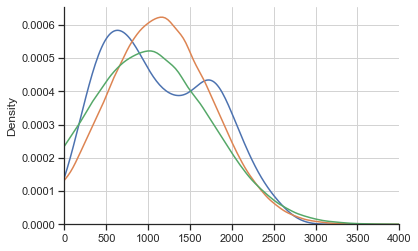

In [155]:
import scipy.stats as stats
from scipy.optimize import root, fsolve

def equations(l_var):
    mu, sigma = l_var
    alpha = -mu/sigma
    phi_a = 1/np.sqrt(2*np.pi) * np.exp(-1/2*(alpha**2))
    Z = 1 - stats.norm.cdf(alpha)
    eq1 = mu + phi_a * sigma / Z - mu_e
    eq2 = (sigma**2) * (1 + alpha*phi_a/Z - (phi_a/(Z**2))**2) - sigma_e**2
    return [eq1, eq2]


class TruncNorm:
    _ctor_param = {"name": "TruncNorm"}
    @staticmethod
    def fit(y):
        mu_e = np.mean(y)
        sigma_e = np.std(y)
        
        solution = fsolve(equations, [mu_e, sigma_e], args=(mu_e, sigma_e))
#         print("Solution:", solution.x)
#         return solution.x
        return solution

    @staticmethod
    def rvs(mu, sigma, size, random_state=42):
        return stats.norm.rvs(mu, sigma, size=size, random_state=random_state)
    
    @staticmethod
    def valid(y):
        mu_e = np.mean(y)
        sigma_e = np.std(y)
        
        params = TruncNorm.fit(y)
        a = TruncNorm.rvs(*params, size=100000, random_state=42)
        a = a[a > 0]
        print(mu_e, np.mean(a))
        print(sigma_e, np.std(a))
        

sns.kdeplot(y_tr["time"])
for st in [stats.norm, TruncNorm, 
#            stats.lognorm, stats.gamma, stats.laplace, stats.laplace_asymmetric, 
#            stats.rayleigh, stats.weibull_min, stats.genlogistic
          ]:
    params = st.fit(y_tr["time"])
    sns.kdeplot(st.rvs(*params, size=100000, random_state=42))
plt.xlim((0, 4000))

In [156]:
TruncNorm.valid(y_["time"])

478.44986271279515 672.3651074279494
560.3524982368881 429.66491014362714


### Informative censuring comparison

In [131]:
from survivors.external.nonparametric import KaplanMeier

X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
bins_HO = cnt.get_bins(time=y[cnt.TIME_NAME], cens=y[cnt.CENS_NAME])

df = X.copy()
df["time"] = y["time"]
df["cens"] = y["cens"]

SF IBS:0.17723, AUPRC:0.28175
SF1 IBS:0.16553, AUPRC:0.29390
SF2 IBS:0.21181, AUPRC:0.36302


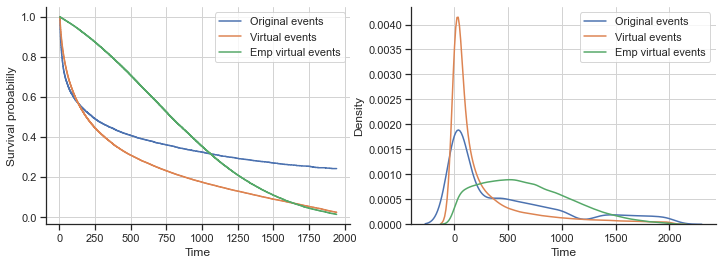

In [148]:
def med_std(x):
    N = len(x)
    d2 = abs(x - np.median(x))**2  # abs is for complex `a`
    var = np.sum(d2) / N  # note use of `ddof`
    return var**0.5

class KaplanMeierZeroAfter(KaplanMeier):
    def fit(self, durations, right_censor, weights=None):
        self.durs = np.array(durations)
        self.events = np.array(right_censor)
        super().fit(self.durs, self.events)

    def survival_function_at_times(self, times):
        place_bin = np.searchsorted(self.timeline, times)
        # place_bin = np.digitize(times, self.timeline)  # -1
        sf = self.survival_function[np.clip(place_bin, 0, None)]
        sf[times > self.timeline[-1]] = 0
        sf[times <= self.timeline[0]] = 1
        return sf
    
class KaplanMeierZeroAfterTh(KaplanMeier):
    def __init__(self, d_type, *args, **kwargs):
        self.d_type = d_type
        super().__init__(*args, **kwargs)
        
    def fit(self, durations, right_censor, weights=None):
#         q1, q2 = np.quantile(durations, [0.05, 0.95])
        params = self.d_type.fit(durations)
#         params = self.d_type.fit(durations[right_censor == 1])
#         params = list(params)
#         params[1] = params[1] / np.sqrt(1.5)
        self.durs = self.d_type.rvs(*params, size=100000, random_state=42)
        self.events = np.random.choice(right_censor, size=100000, replace=True)
#         self.durs = np.hstack([durations.copy(), self.durs])
#         self.events = np.hstack([right_censor.copy(), self.events])

        ind = (self.durs >= durations.min()) & (self.durs <= durations.max())
#         ind = (self.durs >= q1) & (self.durs <= q2)
        self.events = self.events[ind]
        self.durs = self.durs[ind]
        super().fit(self.durs, self.events)

    def survival_function_at_times(self, times):
        place_bin = np.searchsorted(self.timeline, times)
        sf = self.survival_function[np.clip(place_bin, 0, None)]
        sf[times > self.timeline[-1]] = 0
        sf[times <= self.timeline[0]] = 1
        return sf
    
class KaplanMeierZeroAfterEmp(KaplanMeierZeroAfter):
    """
    Nonparametric model with virtual events generated by bootstrap meaning
    """
    def __init__(self, n=2, *args, **kwargs):
        self.n = n
        super().__init__(*args, **kwargs)
        
    def fit(self, durations, right_censor, weights=None):
        self.durs = np.random.choice(durations, size=(self.n, 20000), replace=True).mean(axis=0)
        self.events = np.random.choice(right_censor, size=20000, replace=True)
        
        super().fit(self.durs, self.events)

y_ = y
X_ = X

km = KaplanMeierZeroAfter()
km.fit(y_["time"], y_["cens"])
sf = km.survival_function_at_times(bins_HO)

km1 = KaplanMeierZeroAfterTh(stats.lognorm)
km1.fit(y_["time"], y_["cens"])
sf1 = km1.survival_function_at_times(bins_HO)

km2 = KaplanMeierZeroAfterTh(TruncNorm)
# km2 = KaplanMeierZeroAfterEmp(2)
km2.fit(y_["time"], y_["cens"])
sf2 = km2.survival_function_at_times(bins_HO)

ibs_sf = metr.ibs_remain(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO)
ibs_sf1 = metr.ibs_remain(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO)
ibs_sf2 = metr.ibs_remain(y, y_, np.repeat(sf2[np.newaxis, :], X_.shape[0], axis=0), bins_HO)

auprc_sf = metr.auprc(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO)
auprc_sf1 = metr.auprc(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO)
auprc_sf2 = metr.auprc(y, y_, np.repeat(sf2[np.newaxis, :], X_.shape[0], axis=0), bins_HO)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].step(bins_HO, sf, label="Original events")
axes[0].step(bins_HO, sf1, label="Virtual events")
axes[0].step(bins_HO, sf2, label="Emp virtual events")
axes[0].legend()

sns.kdeplot(km.durs, ax=axes[1], label="Original events")
sns.kdeplot(km1.durs, ax=axes[1], label="Virtual events")
sns.kdeplot(km2.durs, ax=axes[1], label="Emp virtual events")
axes[1].legend()

axes[0].set_xlabel("Time")
axes[0].set_ylabel("Survival probabilily")
axes[1].set_xlabel("Time")
print(f"SF IBS:{ibs_sf:.5f}, AUPRC:{auprc_sf:.5f}")
print(f"SF1 IBS:{ibs_sf1:.5f}, AUPRC:{auprc_sf1:.5f}")
print(f"SF2 IBS:{ibs_sf2:.5f}, AUPRC:{auprc_sf2:.5f}")

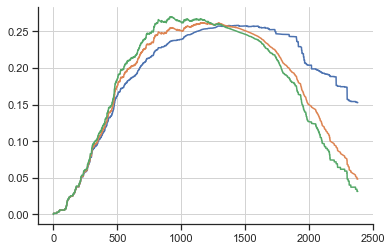

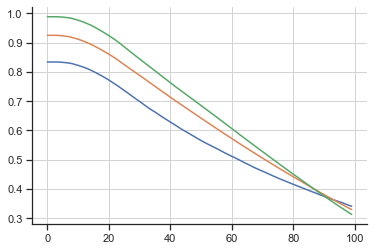

In [134]:
ibs_sf_ = metr.ibs_remain(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)
ibs_sf1_ = metr.ibs_remain(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)
ibs_sf2_ = metr.ibs_remain(y, y_, np.repeat(sf2[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)

plt.plot(ibs_sf_)
plt.plot(ibs_sf1_)
plt.plot(ibs_sf2_)
plt.show()

auprc_sf_ = metr.auprc(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)
auprc_sf1_ = metr.auprc(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)
auprc_sf2_ = metr.auprc(y, y_, np.repeat(sf2[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)
plt.plot(auprc_sf_)
plt.plot(auprc_sf1_)
plt.plot(auprc_sf2_)
plt.show()

<Axes: >

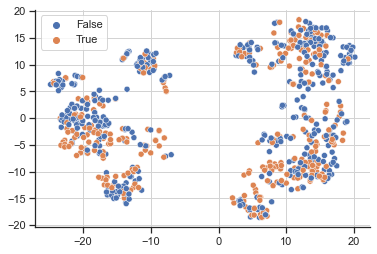

In [135]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X.fillna(X.median()))
X_embedded = TSNE(n_components=2, perplexity=50, learning_rate='auto', random_state=42).fit_transform(X_scaled)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1],
                hue=y["cens"])

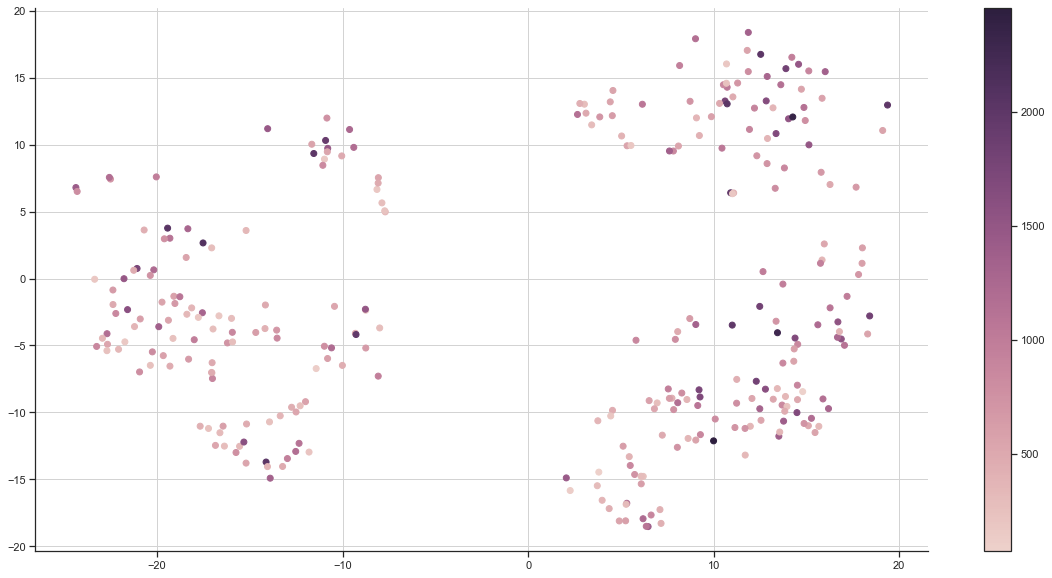

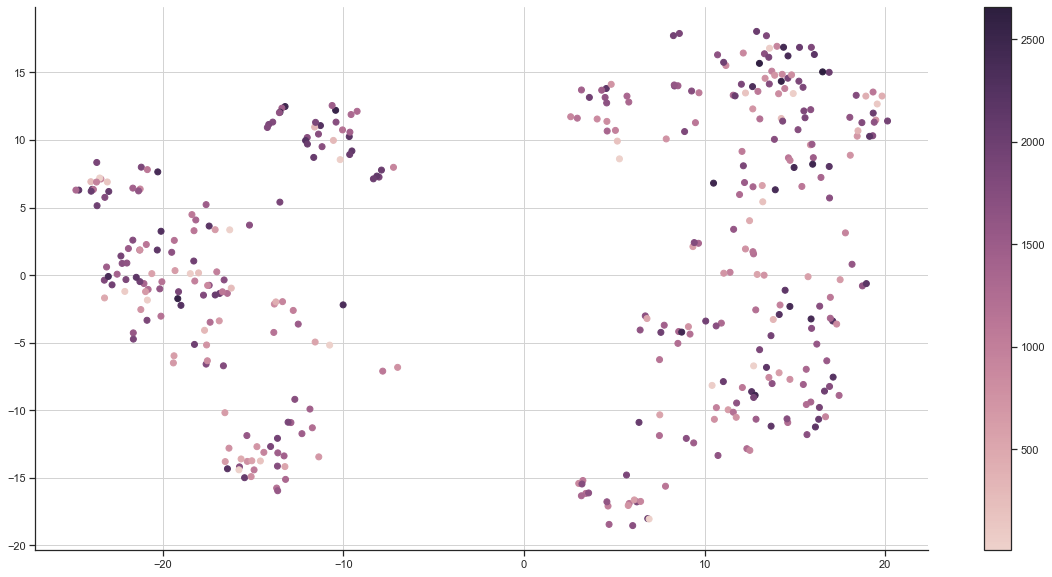

In [136]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(20, 10))
ind = np.where(y["cens"] == 1)[0]
points = ax.scatter(x=X_embedded[ind, 0], y=X_embedded[ind, 1],
                c=y[ind]["time"], cmap=cmap)
f.colorbar(points)

f, ax = plt.subplots(figsize=(20, 10))
ind = np.where(y["cens"] == 0)[0]
points = ax.scatter(x=X_embedded[ind, 0], y=X_embedded[ind, 1],
                c=y[ind]["time"], cmap=cmap)
f.colorbar(points)

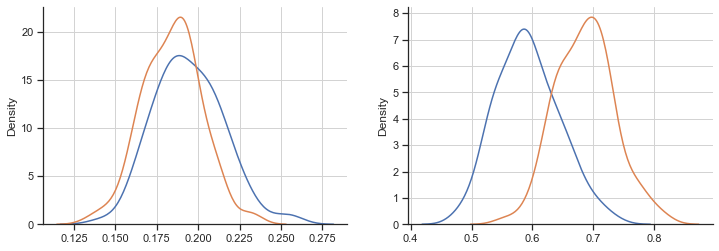

0.1944&0.1843&3.096e-04
0.5926&0.6865&2.403e-29


Text(0, 0.5, '$AUPRC$')

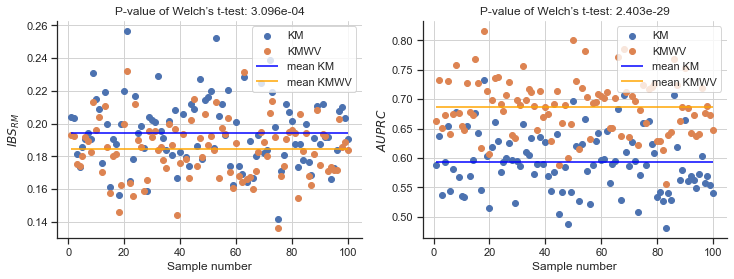

In [137]:
x = np.linspace(1, 100, 100)
ibs_1 = []
ibs_2 = []
auprc_1 = []
auprc_2 = []
np.random.seed(1)

for i, _ in enumerate(x):
    x_sub = df.sample(n=int(X.shape[0]*0.05), replace=True, random_state=i)  #  X.shape[0]*0.05, X.shape[0]*0.3
    time = x_sub["time"].to_numpy()
    cens = x_sub["cens"].to_numpy()
    
    bins_ = cnt.get_bins(time=time)
    y_v = cnt.get_y(cens=cens, time=time)
    
    km = KaplanMeierZeroAfter()
    km.fit(y_v["time"], y_v["cens"])
    sf = km.survival_function_at_times(bins_)

    km1 = KaplanMeierZeroAfterTh(stats.norm)
    km1.fit(y_v["time"], y_v["cens"])
    sf1 = km1.survival_function_at_times(bins_)

    ibs_1.append(metr.ibs_remain(y_v, y_v, np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0), bins_))
    ibs_2.append(metr.ibs_remain(y_v, y_v, np.repeat(sf1[np.newaxis, :], y_v.shape[0], axis=0), bins_))

    auprc_1.append(metr.auprc(y_v, y_v, np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0), bins_))
    auprc_2.append(metr.auprc(y_v, y_v, np.repeat(sf1[np.newaxis, :], y_v.shape[0], axis=0), bins_))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.kdeplot(ibs_1, ax=axes[0])
sns.kdeplot(ibs_2, ax=axes[0])

sns.kdeplot(auprc_1, ax=axes[1])
sns.kdeplot(auprc_2, ax=axes[1])
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(x, ibs_1, label="KM")
axes[0].scatter(x, ibs_2, label="KMWV")
axes[0].hlines([np.mean(ibs_1)], xmin=min(x), xmax=max(x), color="blue", label="mean KM")
axes[0].hlines([np.mean(ibs_2)], xmin=min(x), xmax=max(x), color="orange", label="mean KMWV")
axes[0].set_title(f"P-value of Welch’s t-test: {stats.ttest_ind(ibs_1, ibs_2, equal_var=False).pvalue:.3e}")
axes[0].legend()
axes[0].set_xlabel("Sample number")
axes[0].set_ylabel(r"$IBS_{RM}$")
print(f"{np.mean(ibs_1):.4f}&{np.mean(ibs_2):.4f}&{stats.ttest_ind(ibs_1, ibs_2, equal_var=False).pvalue:.3e}")

axes[1].scatter(x, auprc_1, label="KM")
axes[1].scatter(x, auprc_2, label="KMWV")
axes[1].hlines([np.mean(auprc_1)], xmin=min(x), xmax=max(x), color="blue", label="mean KM")
axes[1].hlines([np.mean(auprc_2)], xmin=min(x), xmax=max(x), color="orange", label="mean KMWV")
axes[1].set_title(f"P-value of Welch’s t-test: {stats.ttest_ind(auprc_1, auprc_2, equal_var=False).pvalue:.3e}")
print(f"{np.mean(auprc_1):.4f}&{np.mean(auprc_2):.4f}&{stats.ttest_ind(auprc_1, auprc_2, equal_var=False).pvalue:.3e}")
axes[1].legend()

axes[1].set_xlabel("Sample number")
axes[1].set_ylabel(r"$AUPRC$")

In [138]:
from survivors.tree import CRAID

def split_by_tree(X, y, categ=[]):
    p = {'balance': None, 'categ': categ, 'criterion': 'peto', 'cut': False, 'depth': 5, 
         'leaf_model': 'base', 'min_samples_leaf': 0.02, 'signif': 0.05, 'woe': True}

    tree = CRAID(**p)
    tree.fit(X, y)
    return tree.predict(X, target="numb")
    

def print_metric_by_nonparam(df, subsample=0.3, prefix="", tree=False, categ=[]):
    ibs_1 = []
    ibs_2 = []
    auprc_1 = []
    auprc_2 = []
    np.random.seed(1)
    
    d = {}
    for i in range(int(1/subsample*5)):
        x_sub = df.sample(n=int(df.shape[0]*subsample), replace=True, random_state=i)  #  X.shape[0]*0.05, X.shape[0]*0.3
        time = x_sub["time"].to_numpy()
        cens = x_sub["cens"].to_numpy()

        bins_ = cnt.get_bins(time=time)
        y_src = cnt.get_y(cens=cens, time=time)
        
        strats = [y_src]
        
#         if tree:
#             X_ = x_sub[[c for c in x_sub.columns if not(c in ["time", "cens"])]]
#             nodes = split_by_tree(X_, y_src, categ=categ)
#             strats = [y_src[np.where(nodes == n)[0]] for n in set(nodes)]
#         print(len(strats))
        for y_v in strats:
            for th in ["", 2, 4, 6, stats.norm, TruncNorm, stats.lognorm, stats.gamma, stats.laplace, 
                       stats.laplace_asymmetric, stats.rayleigh, stats.weibull_min, stats.genlogistic]:
                if th == "":
                    suff = "km"
                    km = KaplanMeierZeroAfter()
                elif isinstance(th, int):
                    suff = f"Emp({th})"
                    km = KaplanMeierZeroAfterEmp(th)
                else:
                    suff = th._ctor_param["name"]
                    km = KaplanMeierZeroAfterTh(th)
                km.fit(y_v["time"], y_v["cens"])
                sf = km.survival_function_at_times(bins_)

                ibs_ = metr.ibs_remain(y_v, y_v, np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0), bins_)
                auprc_ = metr.auprc(y_v, y_v, np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0), bins_)
                if suff+"IBS" in d:
                    d[suff+"IBS"].append(ibs_)
                else:
                    d[suff+"IBS"] = [ibs_]
                if suff+"AUPRC" in d:
                    d[suff+"AUPRC"].append(auprc_)
                else:
                    d[suff+"AUPRC"] = [auprc_]
    
    d_ = {k: np.mean(v) for k, v in d.items()}
    d_["dataset"] = prefix
    d_["subsample"] = subsample
    return d_

#     print(f"{prefix + '|'}IBS:({subsample}): {np.mean(ibs_1):.4f}&{np.mean(ibs_2):.4f}&{stats.ttest_ind(ibs_1, ibs_2, equal_var=False).pvalue:.3e}")
#     print(f"{prefix + '|'}AUPRC({subsample}): {np.mean(auprc_1):.4f}&{np.mean(auprc_2):.4f}&{stats.ttest_ind(auprc_1, auprc_2, equal_var=False).pvalue:.3e}")

In [139]:
from survivors.datasets import DATASETS_LOAD

l = []
for ds_name in ["GBSG", "PBC", "WUHAN", "rott2", "smarto", "support2"]:
    X, y, features, categ, sch_nan = DATASETS_LOAD[ds_name]()
    bins_HO = cnt.get_bins(time=y[cnt.TIME_NAME], cens=y[cnt.CENS_NAME])

    df = X.copy()
    df["time"] = y["time"]
    df["cens"] = y["cens"]
    
    for subsample in [1, 0.7, 0.5, 0.3, 0.1, 0.05]:
        d = print_metric_by_nonparam(df, subsample=subsample, prefix=ds_name, tree=True)
        l.append(d)
        print(d)
#     d = print_metric_by_nonparam(df, subsample=0.3, prefix=ds_name)
#     print(d)
#     l.append(d)
#     d = print_metric_by_nonparam(df, subsample=0.05, prefix=ds_name)
#     print(d)
#     l.append(d)
    
df_res = pd.DataFrame(l).T

{'kmIBS': 0.1845759382639201, 'kmAUPRC': 0.5896996848462435, 'Emp(2)IBS': 0.15811729873118996, 'Emp(2)AUPRC': 0.6883094383779976, 'Emp(4)IBS': 0.16432110471943825, 'Emp(4)AUPRC': 0.699022690681313, 'Emp(6)IBS': 0.17127967074751588, 'Emp(6)AUPRC': 0.700998351989563, 'normIBS': 0.16513360442620498, 'normAUPRC': 0.6791131393128613, 'TruncNormIBS': 0.16222836266654855, 'TruncNormAUPRC': 0.6661167331570729, 'lognormIBS': 0.160246225827597, 'lognormAUPRC': 0.6713122716233902, 'gammaIBS': 0.15952669546777484, 'gammaAUPRC': 0.6686125636560547, 'laplaceIBS': 0.1611188702261106, 'laplaceAUPRC': 0.677581152188106, 'laplace_asymmetricIBS': 0.15641569582692855, 'laplace_asymmetricAUPRC': 0.6608060318303066, 'rayleighIBS': 0.16102671335090885, 'rayleighAUPRC': 0.6705094793225448, 'weibull_minIBS': 0.16052331795297278, 'weibull_minAUPRC': 0.6691507617579632, 'genlogisticIBS': 0.15913690072013348, 'genlogisticAUPRC': 0.66917120476636, 'dataset': 'GBSG', 'subsample': 1}
{'kmIBS': 0.18252654528396256, '

{'kmIBS': 0.19641123752608342, 'kmAUPRC': 0.6035392354494513, 'Emp(2)IBS': 0.17042935191370287, 'Emp(2)AUPRC': 0.6995326105221195, 'Emp(4)IBS': 0.17445782489818004, 'Emp(4)AUPRC': 0.7123514209235837, 'Emp(6)IBS': 0.18115751425057386, 'Emp(6)AUPRC': 0.7149086616030043, 'normIBS': 0.17960449348193525, 'normAUPRC': 0.6964169077767184, 'TruncNormIBS': 0.17755164299202714, 'TruncNormAUPRC': 0.6828380267039491, 'lognormIBS': 0.1741903038581231, 'lognormAUPRC': 0.6869137486372605, 'gammaIBS': 0.17408867942214082, 'gammaAUPRC': 0.6848065782203079, 'laplaceIBS': 0.1720330896414103, 'laplaceAUPRC': 0.6920223550573734, 'laplace_asymmetricIBS': 0.1724723673812525, 'laplace_asymmetricAUPRC': 0.6868712427787906, 'rayleighIBS': 0.17550544615840818, 'rayleighAUPRC': 0.6863956513610815, 'weibull_minIBS': 0.1746282313029589, 'weibull_minAUPRC': 0.6832946881294041, 'genlogisticIBS': 0.17333325498476398, 'genlogisticAUPRC': 0.6851175536282839, 'dataset': 'PBC', 'subsample': 0.3}
{'kmIBS': 0.20227219045754

{'kmIBS': 0.16756347215445774, 'kmAUPRC': 0.5937528486346834, 'Emp(2)IBS': 0.12699156884503068, 'Emp(2)AUPRC': 0.6947480381182612, 'Emp(4)IBS': 0.12962926880923417, 'Emp(4)AUPRC': 0.7054962723804512, 'Emp(6)IBS': 0.13417482485787718, 'Emp(6)AUPRC': 0.7083911646583636, 'normIBS': 0.13528093058038548, 'normAUPRC': 0.680912344715215, 'TruncNormIBS': 0.1351429179602836, 'TruncNormAUPRC': 0.6727626447234808, 'lognormIBS': 0.13584930828554637, 'lognormAUPRC': 0.6778951633802899, 'gammaIBS': 0.13565776455017298, 'gammaAUPRC': 0.6780933667997964, 'laplaceIBS': 0.14053030120570015, 'laplaceAUPRC': 0.6841069648247654, 'laplace_asymmetricIBS': 0.13957901730414418, 'laplace_asymmetricAUPRC': 0.6865265931477813, 'rayleighIBS': 0.13643509543058235, 'rayleighAUPRC': 0.6676487304693716, 'weibull_minIBS': 0.13486119557944606, 'weibull_minAUPRC': 0.6748495013082978, 'genlogisticIBS': 0.13805200007155033, 'genlogisticAUPRC': 0.675930598283116, 'dataset': 'rott2', 'subsample': 1}
{'kmIBS': 0.1660753501050

{'kmIBS': 0.2045336161083286, 'kmAUPRC': 0.845903136405605, 'Emp(2)IBS': 0.1565672957180207, 'Emp(2)AUPRC': 0.887202960939505, 'Emp(4)IBS': 0.14274893513949205, 'Emp(4)AUPRC': 0.8861117937814608, 'Emp(6)IBS': 0.15365483201067198, 'Emp(6)AUPRC': 0.882669539627208, 'normIBS': 0.1775084496424482, 'normAUPRC': 0.8903543077258245, 'TruncNormIBS': 0.18488979996197807, 'TruncNormAUPRC': 0.8878020343411761, 'lognormIBS': 0.1755021001102088, 'lognormAUPRC': 0.880518522060733, 'gammaIBS': 0.17571320110810837, 'gammaAUPRC': 0.874959980781707, 'laplaceIBS': 0.17342460742914775, 'laplaceAUPRC': 0.8858292343264149, 'laplace_asymmetricIBS': 0.17566200510369562, 'laplace_asymmetricAUPRC': 0.8657655433559968, 'rayleighIBS': 0.17636209573982303, 'rayleighAUPRC': 0.8859106615217905, 'weibull_minIBS': 0.17598629313654618, 'weibull_minAUPRC': 0.8779972112677549, 'genlogisticIBS': 0.1756348523050526, 'genlogisticAUPRC': 0.8829181405192081, 'dataset': 'smarto', 'subsample': 0.3}
{'kmIBS': 0.20111997593738054

In [126]:
# df_res.to_csv("./ResultsTable.csv")

In [140]:
df_

,kmIBS,kmAUPRC,Emp(2)IBS,Emp(2)AUPRC,Emp(4)IBS,Emp(4)AUPRC,Emp(6)IBS,Emp(6)AUPRC,normIBS,normAUPRC,...,laplace_asymmetricIBS,laplace_asymmetricAUPRC,rayleighIBS,rayleighAUPRC,weibull_minIBS,weibull_minAUPRC,genlogisticIBS,genlogisticAUPRC,dataset,subsample
30,0.172552,0.281452,0.173533,0.338633,0.186832,0.348762,0.19425,0.351407,0.204542,0.362278,...,0.168626,0.333862,0.194725,0.357455,0.162879,0.314924,0.181108,0.348184,support2,1.0
31,0.173347,0.281961,0.174765,0.340349,0.187865,0.350204,0.195877,0.353208,0.205284,0.363801,...,0.169512,0.335023,0.195696,0.359016,0.162287,0.315037,0.181949,0.349502,support2,0.7
32,0.173005,0.281483,0.174253,0.339355,0.187295,0.349254,0.195126,0.352328,0.205206,0.362992,...,0.169202,0.33454,0.195387,0.358173,0.163805,0.319533,0.181745,0.348919,support2,0.5
33,0.172007,0.282286,0.172748,0.340266,0.185858,0.350353,0.193516,0.353211,0.203496,0.363731,...,0.167762,0.335431,0.19373,0.358952,0.163115,0.32076,0.180091,0.349672,support2,0.3
34,0.172695,0.283079,0.17296,0.341451,0.18594,0.351362,0.193839,0.354423,0.20329,0.364919,...,0.167893,0.336111,0.193654,0.36004,0.162803,0.319448,0.180213,0.350682,support2,0.1
35,0.172573,0.283134,0.173451,0.34016,0.186603,0.349928,0.194508,0.352738,0.204167,0.363267,...,0.168418,0.335074,0.194457,0.3585,0.161542,0.314417,0.180837,0.349294,support2,0.05


GBSG


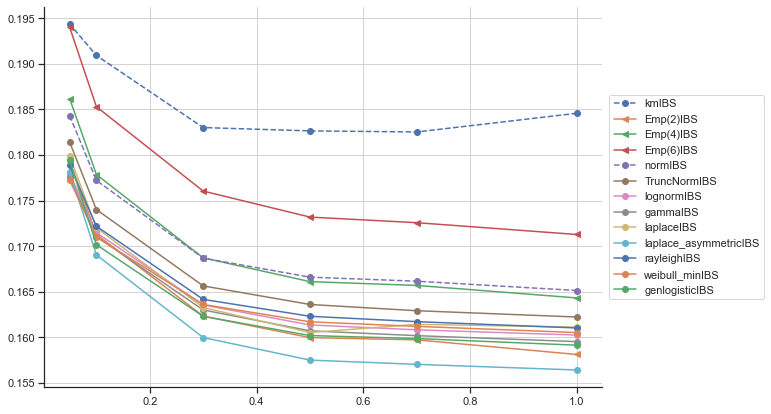

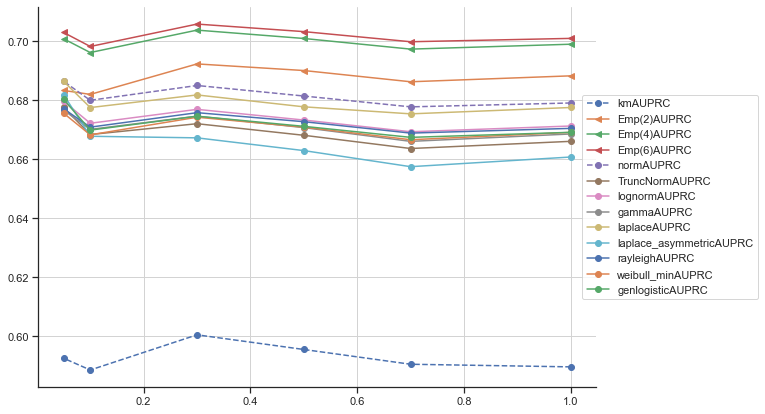

PBC


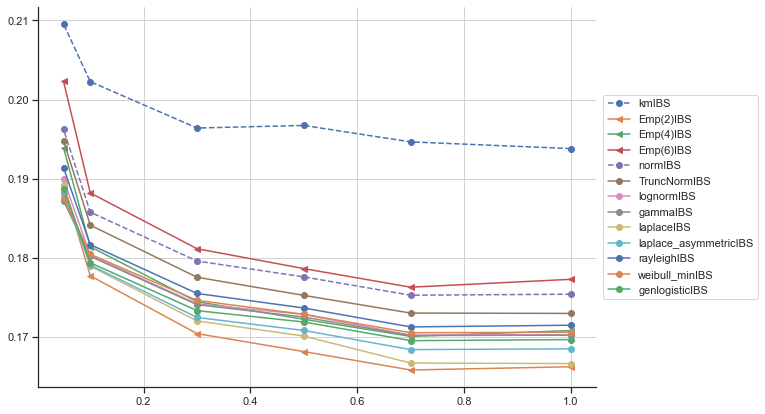

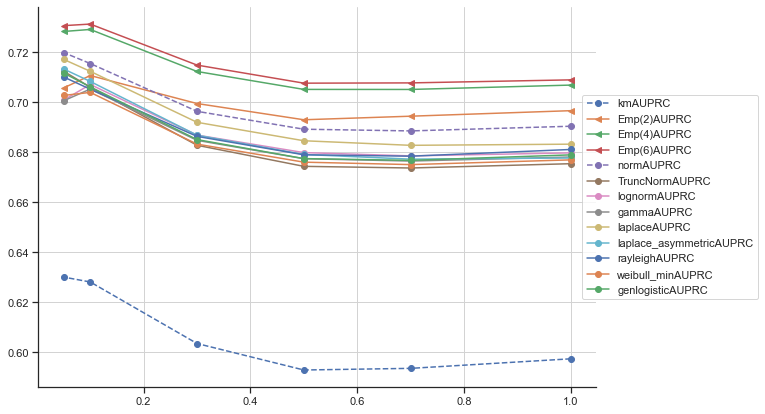

WUHAN


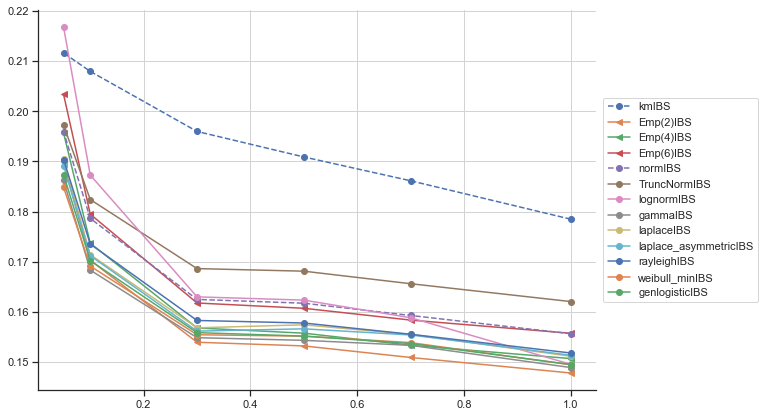

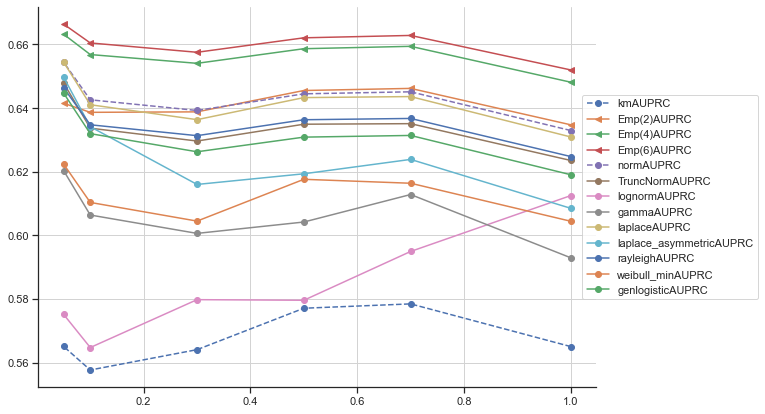

rott2


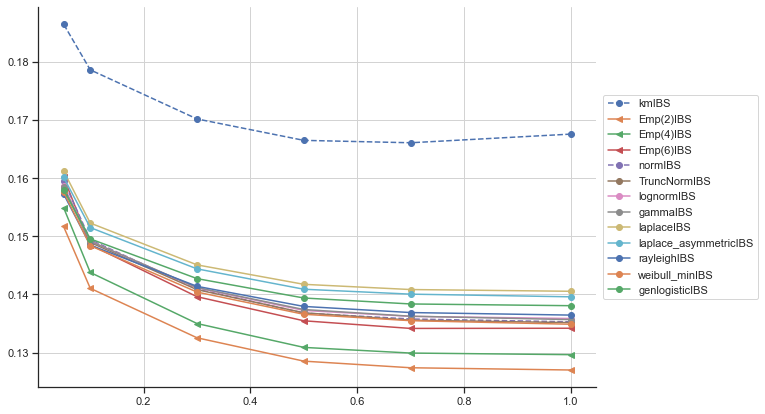

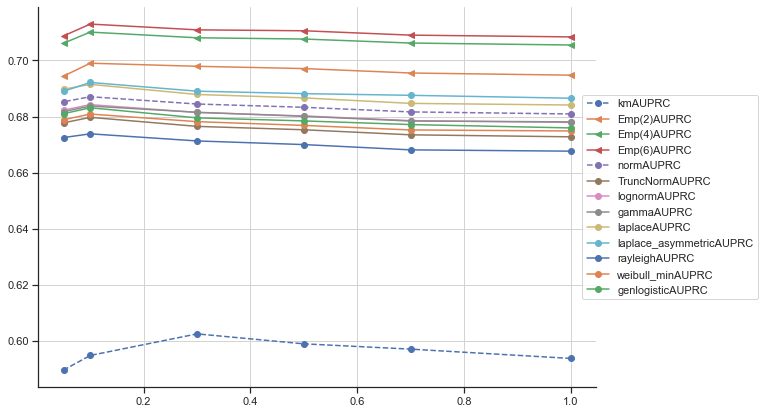

smarto


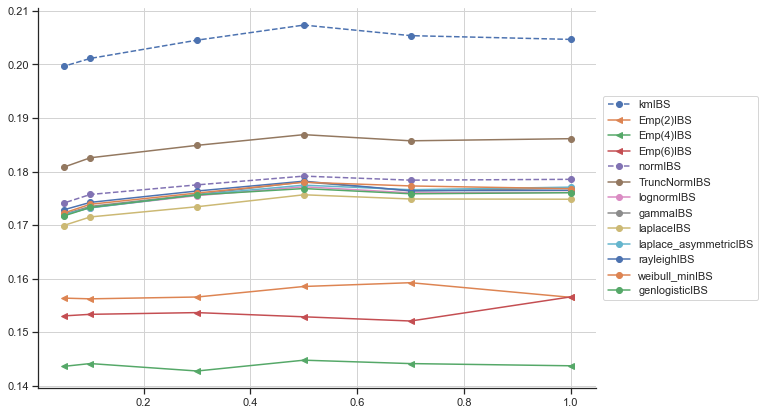

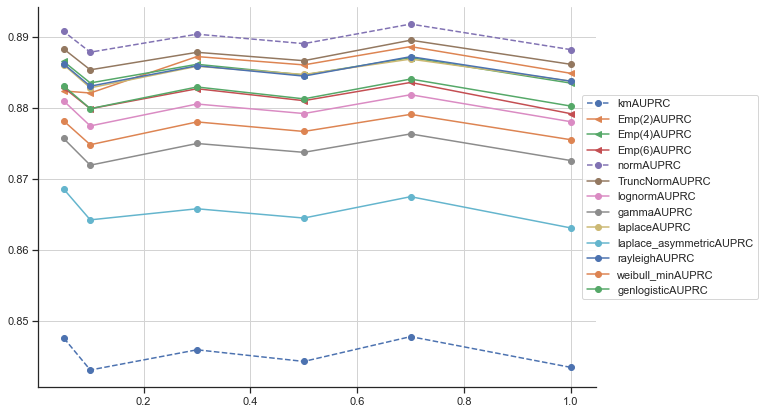

support2


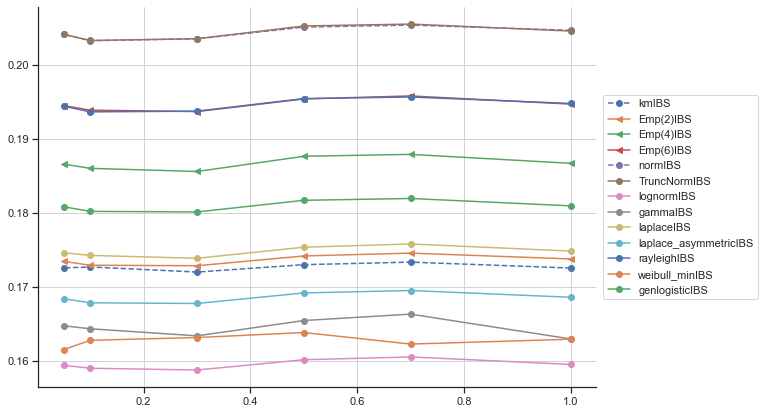

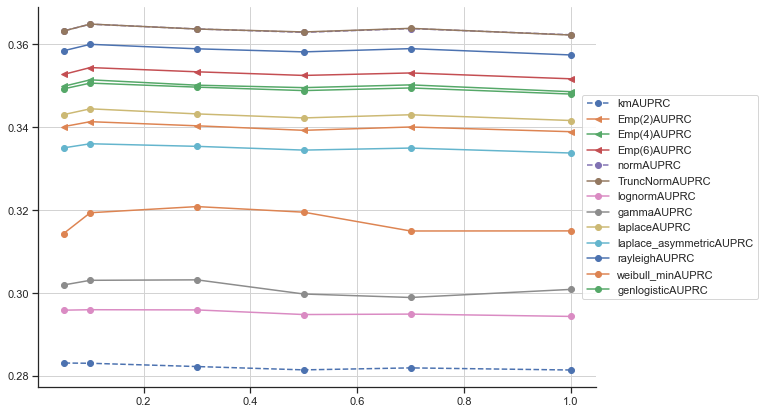

In [141]:
for ds_name in ["GBSG", "PBC", "WUHAN", "rott2", "smarto", "support2"]:
    print(ds_name)
    plt.subplots(figsize=(10, 7))
    for c in df_res.T.columns[:-2:2]:
        df_ = df_res.T
        df_ = df_[df_["dataset"] == ds_name]
        ls = '--' if (("km" in c) or ("norm" in c[:4])) else '-'
        plt.plot(df_["subsample"], df_[c], label=c, marker="<" if "Emp" in c else "o", linestyle=ls)
#         plt.plot(df_["subsample"], 1 - df_[c] / df_["kmIBS"], label=c)
    #plt.legend()
    plt.legend(loc="center right", bbox_to_anchor=(1.3, 0.5))
    plt.show()

    plt.subplots(figsize=(10, 7))
    for c in df_res.T.columns[1:-2:2]:
        df_ = df_res.T
        df_ = df_[df_["dataset"] == ds_name]
        ls = '--' if (("km" in c) or ("norm" in c[:4])) else '-'
        plt.plot(df_["subsample"], df_[c], label=c, marker="<" if "Emp" in c else "o", linestyle=ls)
#         plt.plot(df_["subsample"], df_[c] / df_["kmAUPRC"] - 1, label=c)
    #plt.legend()
    plt.legend(loc="center right", bbox_to_anchor=(1.3, 0.5))
    plt.show()

In [142]:
print(df_res.iloc[:-2:2].rank().mean(axis=1).sort_values())
print(df_res.iloc[1:-2:2].rank(ascending=False).mean(axis=1).sort_values())

for g in df_res.loc["dataset"].unique():
    print("="*10, g, "="*10)
    g_sample = (df_res.T[df_res.T["dataset"] == g]).T
    print(g_sample.iloc[:-2:2].rank().mean(axis=1).sort_values())
    print(g_sample.iloc[1:-2:2].rank(ascending=False).mean(axis=1).sort_values())

Emp(2)IBS                 2.833333
gammaIBS                  4.805556
weibull_minIBS            4.861111
laplace_asymmetricIBS     5.416667
genlogisticIBS            5.611111
Emp(4)IBS                 5.916667
lognormIBS                6.055556
laplaceIBS                6.500000
rayleighIBS               8.444444
Emp(6)IBS                 8.527778
TruncNormIBS             10.138889
normIBS                  10.250000
kmIBS                    11.638889
dtype: float64
Emp(6)AUPRC                 2.638889
Emp(4)AUPRC                 2.888889
normAUPRC                   3.277778
Emp(2)AUPRC                 4.583333
laplaceAUPRC                5.138889
rayleighAUPRC               6.888889
TruncNormAUPRC              7.083333
genlogisticAUPRC            7.750000
laplace_asymmetricAUPRC     8.583333
lognormAUPRC                8.888889
gammaAUPRC                 10.083333
weibull_minAUPRC           10.194444
kmAUPRC                    13.000000
dtype: float64
========== GBSG ==========
laplace

In [143]:
df_ibs_rank = df_res.iloc[:-2:2].rank()
df_ibs_rank.index = df_ibs_rank.index.str[:-3]

df_auprc_rank = df_res.iloc[1:-2:2].rank(ascending=False)
df_auprc_rank.index = df_auprc_rank.index.str[:-5]

print(pd.concat([df_ibs_rank, df_auprc_rank], axis=1).mean(axis=1).sort_values())

Emp(2)                 3.708333
Emp(4)                 4.402778
Emp(6)                 5.583333
laplace                5.819444
genlogistic            6.680556
norm                   6.763889
laplace_asymmetric     7.000000
gamma                  7.444444
lognorm                7.472222
weibull_min            7.527778
rayleigh               7.666667
TruncNorm              8.611111
km                    12.319444
dtype: float64


In [144]:
# IBS growth
1 - df_res.iloc[:-2:2] / df_res.iloc[[0]].values

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
kmIBS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Emp(2)IBS,0.143348,0.124935,0.124168,0.113014,0.102748,0.077462,0.142242,0.148083,0.145246,0.132283,...,0.235433,0.234516,0.223221,0.216788,-0.0071,-0.007036,-0.006795,-0.004973,-0.001349,-0.005084
Emp(4)IBS,0.109737,0.092234,0.090531,0.078077,0.068416,0.042065,0.118646,0.126252,0.124464,0.111773,...,0.30181,0.302076,0.283318,0.280665,-0.082004,-0.084017,-0.084676,-0.079006,-0.077182,-0.081267
Emp(6)IBS,0.072037,0.054521,0.051779,0.038062,0.029434,0.001844,0.085231,0.094329,0.091945,0.077662,...,0.262741,0.248755,0.237601,0.233451,-0.128371,-0.129556,-0.129458,-0.12609,-0.122697,-0.127091
normIBS,0.105335,0.089688,0.087853,0.078238,0.071782,0.051787,0.094934,0.099535,0.097276,0.085569,...,0.136037,0.132131,0.126324,0.127943,-0.186188,-0.184803,-0.18558,-0.183235,-0.177041,-0.182972
TruncNormIBS,0.121075,0.107429,0.10425,0.094899,0.088536,0.066689,0.107463,0.111112,0.109156,0.096021,...,0.098685,0.096042,0.092241,0.094363,-0.185576,-0.185588,-0.18644,-0.183332,-0.177235,-0.182899
lognormIBS,0.131814,0.118902,0.116551,0.106313,0.101803,0.084342,0.12132,0.125497,0.121381,0.113135,...,0.14564,0.14194,0.138432,0.139143,0.075491,0.073898,0.074262,0.076951,0.079235,0.076307
gammaIBS,0.135712,0.122408,0.120083,0.109327,0.104063,0.086302,0.121645,0.125681,0.123098,0.113652,...,0.141203,0.140908,0.137355,0.138373,0.055567,0.040531,0.043636,0.05012,0.04836,0.04535
laplaceIBS,0.127086,0.115593,0.12111,0.107873,0.098983,0.07464,0.140167,0.143552,0.135287,0.124118,...,0.152842,0.152097,0.147187,0.148905,-0.013267,-0.014162,-0.013641,-0.010819,-0.009058,-0.011807
laplace_asymmetricIBS,0.152567,0.139648,0.137661,0.125846,0.114575,0.083403,0.130552,0.134834,0.131681,0.121881,...,0.144172,0.141158,0.138799,0.138686,0.022901,0.022116,0.022092,0.024687,0.028031,0.02417


In [145]:
# AUPRC growth
df_res.iloc[1:-2:2] / df_res.iloc[[1]].values - 1

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
kmAUPRC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Emp(2)AUPRC,0.16722,0.162064,0.158698,0.152839,0.158638,0.1531,0.166135,0.169914,0.168812,0.159051,...,0.04947,0.048823,0.046275,0.041005,0.204315,0.206175,0.205363,0.205789,0.205931,0.201468
Emp(4)AUPRC,0.185388,0.180794,0.176933,0.171909,0.182737,0.18263,0.183266,0.187936,0.18929,0.18029,...,0.047789,0.047533,0.047958,0.045908,0.238612,0.242209,0.241957,0.240512,0.241606,0.235848
Emp(6)AUPRC,0.188738,0.185028,0.180832,0.175317,0.18622,0.186246,0.186761,0.192355,0.193497,0.184527,...,0.043502,0.043464,0.043645,0.041572,0.249669,0.252416,0.252416,0.251957,0.25206,0.245967
normAUPRC,0.151625,0.147672,0.144192,0.140667,0.155236,0.158334,0.155713,0.159997,0.162437,0.153888,...,0.053016,0.052549,0.053093,0.050905,0.287408,0.290399,0.289381,0.288574,0.289068,0.283014
TruncNormAUPRC,0.129586,0.123773,0.121852,0.119111,0.135542,0.143414,0.130632,0.135011,0.137391,0.13139,...,0.050172,0.049532,0.050148,0.047999,0.287192,0.290581,0.289686,0.28854,0.289133,0.282958
lognormAUPRC,0.138397,0.133386,0.13053,0.12721,0.142022,0.146904,0.137877,0.143175,0.146657,0.138143,...,0.041354,0.040921,0.040777,0.039365,0.045946,0.046041,0.047437,0.048406,0.045642,0.04504
gammaAUPRC,0.133819,0.127871,0.126217,0.123361,0.138501,0.141823,0.135125,0.13968,0.142537,0.134651,...,0.034882,0.03435,0.034217,0.03312,0.069112,0.060264,0.065037,0.074106,0.070715,0.066522
laplaceAUPRC,0.149027,0.143657,0.138048,0.135341,0.151063,0.158268,0.143706,0.150286,0.154649,0.146607,...,0.047871,0.047199,0.047138,0.045379,0.213915,0.216644,0.215989,0.215969,0.216895,0.2117
laplace_asymmetricAUPRC,0.120581,0.113347,0.113149,0.111128,0.134541,0.150696,0.134445,0.140976,0.145396,0.138072,...,0.023922,0.023481,0.025083,0.024732,0.18604,0.188135,0.188402,0.188235,0.187117,0.183364
